# Data journalism: data visualisation – implementation of interactive graphs (web enabled), infographics.

This notebook explores how sentiment and metadata from social media posts can be used to predict user engagement (likes + retweets). We also correlate trending news topics to online activity. This will help jouranlists find tredning topics via Social media and see how they effect each other. 

This project delivers a real-time trend forecasting web app that analyzes world-related hashtags (e.g., #Fitness, #Climate Change, #Ukraine) on X and Reddit posts combined. It combines social media data with current news headlines (via the News API) Using NLP and machine learning, it extracts trending keywords, predicts post engagement (likes and retweets, upvotes), and forecasts topic popularity over 24–48 hours. The tool is deployed as an interactive Streamlit dashboard, offering visualizations like word clouds and trend curves. A Jupyter notebook documents the full data science workflow.


# Problem Statement: 

Trends on social media emerge and fade rapidly. Marketers, journalists, and researchers often struggle to anticipate these shifts. This project addresses that challenge by forecasting trend lifecycles, helping users optimize content timing and stay ahead of competitors.

## Objectives: 

1. To collect and preprocess real-time social media data from X (formerly Twitter) and Reddit, focusing on globally relevant hashtags (e.g., #ClimateChange, #Ukraine, #Fitness), along with current news headlines using the NewsAPI.
2. To perform sentiment analysis and keyword extraction on social media posts and news headlines using Natural Language Processing (NLP) techniques.
3. To develop predictive models that estimate user engagement, such as likes, retweets, and upvotes, based on post content, sentiment, and metadata (e.g., time posted, hashtag used).
4. To forecast the popularity of trending topics over a 24–48 hour period using time series analysis and trend modeling.
5. To analyze the correlation between news coverage and online social media activity, highlighting how news drives or reflects online trends.
6. To build and deploy an interactive Streamlit dashboard that:

#### Displays real-time trends,

#### Visualizes sentiment and keyword patterns (e.g., word clouds, trend curves),

#### Allows journalists and users to explore topic impact and forecast engagement.

7. To Document process

### Libraries Needed: 



In [3]:
from IPython.display import Image, display


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import praw
from datetime import datetime

streamlit
nltk
scikit-learn
pandas
matplotlib
numpy
seaborn
wordcloud
statsmodels
praw
textblob




ModuleNotFoundError: No module named 'pandas'

# Data Collection

## Data sources: 
For social media, we use the X api [1]. This allows you gather posts from X within defined parameters. This will be done using hashtags these usally represent trending topics [2]. The newsAPI [3] will be used to gather news articles based on the paramters from the X posts aswell as Reddit [4] posts, for example #Fitness retreived the posts will be the search paramter for the news posts. 

## *Please add other data sources here if used*


1. https://docs.x.com/x-api/introduction
2. https://www.shopify.com/nz/blog/twitter-hashtags
3. https://newsapi.org/
4. https://www.reddit.com/dev/api/

# Limitations: 

Within the bounds of the X api free acount you are entitled to 100 posts from X, with Reddit its a lot more but capped to 60 requests a minute. The combined dataset will give us roughly 600 bits of data to work with with the abilty to add more from reddit when needed. This may skew the data towards Reddit posts but by doing the sentiment scores it will average out over all the data. 

# Ethical data usage: 


### X: 
The X API can be used for a university project if it aligns with X’s License Agreement, prioritizing user privacy, transparency, and ethical data use while avoiding harmful applications like misinformation or unauthorized data scraping. Ensure compliance with platform policies and secure data handling, especially for public interest research, though access may require navigating paid tiers or specific approvals under regulations like the EU’s DSA. (https://developer.x.com/en/developer-terms/agreement-and-policy) 

### NewsAPI: 
The News API (https://newsapi.org/terms) can be ethically used for a university project by adhering to its terms, which require lawful data use, compliance with local regulations, and respecting intellectual property through proper source attribution. Ensure transparency, secure handling of the API key, and limit data use to non-commercial academic purposes within the free tier’s 500 requests/day, avoiding unauthorized redistribution of licensed content.


### Here is how the NewsAPI is used. This wont run on this notebook. 


In [3]:

# --- Initialize News API ---
API_KEY = "7af7d5e56edc4148aac908f2c9f86ac3"  
newsapi = NewsApiClient(api_key=API_KEY)

st.title("📊 Real-Time Social + News Dashboard with Engagement Forecasting")

# --- User Topic Input ---
topic = st.text_input("Enter a topic keyword (e.g., #Fitness, climate change):", "#Fitness")

# --- News Fetching ---
if topic:
    with st.spinner("Fetching news articles..."):
        all_articles = newsapi.get_everything(
            q=topic,
            language='en',
            sort_by='publishedAt',
            page_size=10
        )
    articles = all_articles.get('articles', [])

    st.header(f"📰 Latest News on {topic}")
    if articles:
        for article in articles:
            st.subheader(article['title'])
            st.write(article['description'])
            st.markdown(f"[Read more]({article['url']})")
            st.write(f"Published at: {article['publishedAt']}")
            st.markdown("---")
    else:
        st.write("No news articles found for this topic.")

# --- Load Dataset ---
@st.cache_data
def load_social_data():
    df = pd.read_csv("data/x_posts_with_weather.csv")
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    return df

df = load_social_data()

# --- Filter Dataset ---
if topic:
    mask = df['hashtags'].str.contains(topic.replace("#", ""), case=False, na=False)
    filtered_df = df[mask]

    st.header(f"📱 Social Media Posts on {topic}")
    st.write(f"Total posts found: {filtered_df.shape[0]}")

    if not filtered_df.empty:
        st.line_chart(filtered_df.groupby(filtered_df['created_at'].dt.floor('H')).size())
    else:
        st.write("No social media posts found for this topic.")

NameError: name 'NewsApiClient' is not defined

# Reddit Data: 

Reddit uses a libary named 'praw', this is an API wrapper for reddit and is what receives the posts from Reddit. It does require an client ID, client_secret and user_agent which is given to you when you create an app through Reddit developer. 


https://praw.readthedocs.io/en/stable/

## Code Example: 

In [ ]:

# Reddit API credentials
reddit = praw.Reddit(
    client_id='v5b2CYNg37amXniM43bNmQ',
    client_secret='cqVeL5VR-vENbiLAjnfC-xoRn45qaQ',
    user_agent="MyRedditSentimentApp/0.1 by noahcrampton"
)

subreddit = reddit.subreddit("all")
posts = []

# You can use .hot(), .new(), or .top(), ill use hot() to get treding postss
for post in subreddit.new(limit=500):
    posts.append({
        "title": post.title,
        "score": post.score,
        "comments": post.num_comments,
        "created": datetime.utcfromtimestamp(post.created_utc),
        "url": post.url,
        "selftext": post.selftext,
        "subreddit": str(post.subreddit)
    })

df = pd.DataFrame(posts).drop_duplicates(subset="title")
df.sort_values(by="created", ascending=False, inplace=True)

print("Columns:", df.columns.tolist())

df.to_csv("data/reddit_all_recent_posts.csv", index=False)
print("Saved to reddit_all_recent_posts.csv")


# Data Cleaning & Preprocessing

Below is the code that cleans and organises the data, ensures there is simuilar colunm names for machine learning

In [ ]:


x_posts = pd.read_csv("data/x_posts_with_weather.csv")
reddit_posts = pd.read_csv("data/reddit_all_recent_posts.csv")

reddit_posts['text'] = reddit_posts['title'].fillna('') + ". " + reddit_posts['selftext'].fillna('')

reddit_posts['created_at'] = pd.to_datetime(reddit_posts['created'], errors='coerce')

reddit_posts['hour_of_day'] = reddit_posts['created_at'].dt.hour
reddit_posts['is_weekend'] = reddit_posts['created_at'].dt.dayofweek >= 5

reddit_posts['engagement'] = reddit_posts['score'] + reddit_posts['comments']

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

reddit_posts['sentiment'] = reddit_posts['text'].apply(get_sentiment)

reddit_renamed = reddit_posts.rename(columns={
    "created_at": "created_at",
    "text": "text",
    "engagement": "engagement",
    "sentiment": "sentiment",
    "hour_of_day": "hour_of_day",
    "is_weekend": "is_weekend"
})

reddit_cleaned = reddit_renamed[[
    "created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"
]]

x_posts['created_at'] = pd.to_datetime(x_posts['created_at'], errors='coerce')
x_posts_cleaned = x_posts[[
    "created_at", "text", "sentiment", "hour_of_day", "is_weekend", "engagement"
]]

combined_df = pd.concat([x_posts_cleaned, reddit_cleaned], ignore_index=True)

combined_df.dropna(subset=["text", "engagement"], inplace=True)

combined_df.to_csv("data/combined_social_data.csv", index=False)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     

print(combined_df)

This preprocess_and_train() function is a machine learning pipeline for training a regression model to predict engagement (like likes, comments, etc.) based on various post features. Splits the dataset into training (80%) and testing (20%) sets using a fixed random seed for reproducibility. Chooses and initializes the machine learning model, user chooses the model via the Streamlit app:

RandomForestRegressor: ensemble method using many decision trees.

GradientBoostingRegressor: more sophisticated, sequentially improves weak learners.

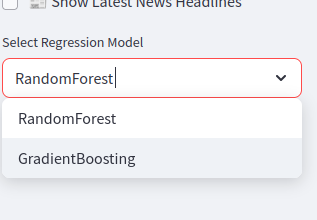

In [2]:

display(Image(filename='Images/screen1.png'))

In [ ]:
def preprocess_and_train(df, model_choice="RandomForest"):
    try:
        features = ['sentiment', 'text_length', 'hashtag_count', 'is_media', 'hour', 'is_weekend']
        X = df[features].fillna(0)
        y = df['engagement'].fillna(0)
        if len(X) < 10:
            raise ValueError("Not enough data for training (minimum 10 rows required).")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        if model_choice == "RandomForest":
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return {
            'r2_score': r2_score(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred
        }
    except Exception as e:
        st.error(f"Error in training model: {e}")
        return None

# Exploratory Data Analysis (EDA)

# Model Development

### Hybrid Prophet+XGBoost

This code snippet is part of the Streamlit app that implements a hybrid forecasting model combining Facebook Prophet and XGBoost to predict engagement over time (e.g., likes, shares, comments, etc.) Evaluates it with R² and RMSE. Plots:

    1. Time-series forecast from Prophet.

    2. Predicted vs. actual engagement using XGBoost.

    as seen in the EDA section

In [ ]:
st.subheader("Hybrid Prophet + XGBoost Forecast")
try:
    with st.spinner("Training hybrid model..."):
        result = hybrid_prophet_xgb(filtered_df)
    if result:
        st.success("✅ Hybrid model trained successfully!")
        st.write(f"**R² Score**: {result['r2_score']:.2f}")
        st.write(f"**RMSE**: {result['rmse']:.2f}")
        fig = plt.figure(figsize=(12, 6))
        plt.plot(result['prophet_forecast']['ds'], result['prophet_forecast']['yhat'], label='Prophet Forecast')
        plt.xlabel('Time')
        plt.ylabel('Engagement')
        plt.title('Prophet Time Series Forecast')
        plt.legend()
        st.pyplot(fig)
        chart_df = result['X_test'].copy()
        chart_df['Predicted Engagement'] = result['y_pred']
        chart_df['Actual Engagement'] = result['y_test'].values
        if 'created_at' in chart_df.columns and not chart_df['created_at'].isnull().any():
            chart_df = chart_df.set_index('created_at')
            st.line_chart(chart_df[['Predicted Engagement', 'Actual Engagement']])
        else:
            st.line_chart(chart_df[['Predicted Engagement', 'Actual Engagement']])
            st.warning("Using post indices as x-axis because 'created_at' is missing or invalid.")
except Exception as e:
    st.error(f"Hybrid model error: {e}")

In [ ]:
def hybrid_prophet_xgb(df):
    try:
        logger.info("Starting hybrid Prophet+XGBoost prediction")
        df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
        prophet_df = df[['created_at', 'engagement']].copy()
        prophet_df = prophet_df.rename(columns={'created_at': 'ds', 'engagement': 'y'})
        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
        m.fit(prophet_df)
        future = m.make_future_dataframe(periods=24, freq='H')
        forecast = m.predict(future)
        prophet_features = forecast[['ds', 'trend', 'weekly', 'daily']]
        merged_df = df.merge(prophet_features, left_on='created_at', right_on='ds', how='left').drop(columns=['ds'])
        features = ['sentiment', 'hour', 'is_weekend', 'trend', 'weekly', 'daily']
        merged_df = merged_df.dropna(subset=features + ['engagement'])
        if len(merged_df) < 10:
            raise ValueError("Not enough data for XGBoost training.")
        X = merged_df[features]
        y = merged_df['engagement']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        xgb_model = XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        return {
            "prophet_forecast": forecast[['ds', 'yhat']],
            "xgb_model": xgb_model,
            "xgb_features": features,
            "r2_score": r2_score(y_test, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
            "X_test": X_test.assign(created_at=merged_df.loc[X_test.index, 'created_at']),
            "y_test": y_test,
            "y_pred": y_pred
        }
    except Exception as e:
        logger.error(f"Hybrid model error: {str(e)}", exc_info=True)
        return None

### Regression model

This code snippet is part of the Streamlit app that performs regression-based engagement prediction using a machine learning model selected by the user based on selected input via the app, #Fitness for example

In [ ]:
st.subheader("📈 Predict Engagement (Regression)")
try:
    with st.spinner("Training regression model..."):
        result = preprocess_and_train(filtered_df, model_choice)
    if result:
        st.success(f"✅ {model_choice} model trained successfully!")
        st.write(f"**R² Score**: {result['r2_score']:.2f}")
        st.write(f"**RMSE**: {result['rmse']:.2f}")
        chart_df = result['X_test'].copy()
        chart_df['Predicted Engagement'] = result['y_pred']
        chart_df['Actual Engagement'] = result['y_test'].values
        fig, ax = plt.subplots()
        ax.plot(chart_df.index, chart_df['Predicted Engagement'], label='Predicted', color='tab:purple')
        ax.plot(chart_df.index, chart_df['Actual Engagement'], label='Actual', color='tab:red')
        ax.set_title('Predicted vs Actual Engagement')
        ax.set_xlabel('Post Index')
        ax.set_ylabel('Engagement')
        ax.legend()
        st.pyplot(fig)

except Exception as e:
    st.error(f"Regression model error: {e}")

### NLP / LDA

The list nltk_resources contains names of NLTK datasets and models that need to be downloaded to use certain Natural Language Toolkit (NLTK) features.

In [4]:
nltk_resources = [
    'punkt', 'punkt_tab', 'stopwords', 'vader_lexicon',
    'averaged_perceptron_tagger', 'wordnet', 'omw-1.4'
]

The extract_topics function preprocesses a list of texts (removing stopwords, tokenizing, and filtering) and uses Latent Dirichlet Allocation (LDA) to assign one of three topic labels to each valid text. If there’s too little data or an error occurs, it returns a list of zeros matching the input size.

In [ ]:
def extract_topics(texts):
    stop_words = set(stopwords.words('english')) - {'run', 'pump'}
    processed_texts = [
        " ".join([
            word for word in word_tokenize(doc.lower())
            if (word.isalnum() or word.startswith('#') or word in ['🦵🏽', '💪🏽']) and word not in stop_words
        ]) for doc in texts if isinstance(doc, str) and doc.strip()
    ]
    processed_texts = [doc for doc in processed_texts if len(doc.strip().split()) > 1]
    if len(processed_texts) < 5:
        return [0] * len(texts)
    try:
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
        dtm = vectorizer.fit_transform(processed_texts)
        lda = LatentDirichletAllocation(n_components=3, random_state=42)
        lda.fit(dtm)
        topics = lda.transform(dtm).argmax(axis=1)
        padded_topics = [topics[i] if i < len(topics) else 0 for i in range(len(texts))]
        return padded_topics
    except Exception as e:
        logger.error(f"Topic modeling error: {e}")
        return [0] * len(texts)

### VADER Sentiment 


In [ ]:
try:
    sid = SentimentIntensityAnalyzer()
    test_score = sid.polarity_scores("I love this! It's amazing!")
    logger.debug(f"VADER test score: {test_score}")
    if test_score['compound'] == 0:
        st.warning("VADER sentiment analyzer may not be functioning correctly.")
except Exception as e:
    st.error(f"Failed to initialize VADER: {e}")
    st.stop()

In [ ]:
def compute_sentiment(text):
    try:
        text = str(text).strip()
        if not text or text.lower() in ['nan', 'none', '']:
            logger.debug(f"Empty or invalid text: {text}")
            return 0.0
        scores = sid.polarity_scores(text)
        compound_score = scores['compound']
        logger.debug(f"Text: {text[:50]}... Sentiment: {compound_score}")
        return compound_score
    except Exception as e:
        logger.error(f"Sentiment computation error for text '{text[:50]}...': {e}")
        return 0.0

This function ensures robust and fault-tolerant sentiment scoring using VADER, returning a compound score between -1 and 1, and defaulting to 0.0 for any invalid input or error.

# Model Evaluation

# Forecasting & Trend Analysis

# Streamlit App Integration

# Insights & Conclusion